In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/kaggle/Imdb movie reviews

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks/kaggle/Imdb movie reviews


In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from IPython.display import SVG
#from keras.utils import model_to_dot
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report,accuracy_score

In [3]:
data=pd.read_csv("./data/Train.csv")
test=pd.read_csv("./data/Test.csv")
valid=pd.read_csv("./data/Valid.csv")
print(data.info())
print("x"*40)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB
None
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB
None


In [4]:
data.label.value_counts()

0    20019
1    19981
Name: label, dtype: int64

In [5]:
words=[]
for sent in data.text:
  words.extend(sent.split())

words_arr=np.array(words)
print("total no of uniques words ",np.unique(words_arr).shape)
print(np.unique(words_arr, return_counts=True))
del words_arr
del words

total no of uniques words  (381542,)
(array(['\x10own', '!', '!!', ..., '₤250,000', '★★', '\uf0b7'],
      dtype='<U78'), array([  1, 944,  67, ...,   1,   1,   2]))


In [6]:
# data_path = keras.utils.get_file(
#     "news20.tar.gz",
#     "http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz",
#     untar=True,
# )
# print(data_path)

In [7]:
# import os
# import pathlib

# data_dir = pathlib.Path(data_path).parent / "20_newsgroup"
# dirnames = os.listdir(data_dir)
# print("Number of directories:", len(dirnames))
# print("Directory names:", dirnames)

# fnames = os.listdir(data_dir / "comp.graphics")
# print("Number of files in comp.graphics:", len(fnames))
# print("Some example filenames:", fnames[:5])

In [47]:
MAX_NUM_WORDS=40000
MAX_SEQUENCE_LENGTH=200

In [48]:
X=data.text
y=data.label
X_test=valid.text
y_test=valid.label

## Create a vocabulary index

Let's use the `TextVectorization` to index the vocabulary found in the dataset.
Later, we'll use the same layer instance to vectorize the samples.

Our layer will only consider the top 30,000 words, and will truncate or pad sequences to
be actually 200 tokens long.

In [49]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=MAX_NUM_WORDS, output_sequence_length=MAX_SEQUENCE_LENGTH)
text_ds = tf.data.Dataset.from_tensor_slices(X).batch(64)
vectorizer.adapt(text_ds)

In [50]:
# print(len(list(text_ds)))
# print(list(text_ds)[1].shape)
# print(list(text_ds)[1])

In [51]:
# dir(vectorizer)

In [52]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'a']

In [53]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0, :6]

array([    2,  1191,  1711,    21,     2, 15465])

As you can see, "the" gets represented as "2". Why not 0, given that "the" was the first word in the vocabulary? That's because index 0 is reserved for padding and index 1 is reserved for "out of vocabulary" tokens.

Here's a dict mapping words to their indices:

In [54]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))


test_sen = ["the", "cat", "sat", "on", "the", "mat"]
[word_index[w] for w in test_sen]

[2, 1191, 1711, 21, 2, 15465]

## Load pre-trained word embeddings

In [55]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [56]:
import os
path_to_glove_file = os.path.join(
    "glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Now, let's prepare a corresponding embedding matrix that we can use in a Keras
`Embedding` layer. It's a simple NumPy matrix where entry at index `i` is the pre-trained
vector for the word of index `i` in our `vectorizer`'s vocabulary.

In [57]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 34723 words (5277 misses)


### Embedding layer

In [58]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

## Build the model

> A simple 1D convnet with global max pooling and a classifier at the end.

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 100)         4000200   
_________________________________________________________________
conv1d_21 (Conv1D)           (None, None, 16)          8016      
_________________________________________________________________
dropout_21 (Dropout)         (None, None, 16)          0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, None, 16)          1296      
_________________________________________________________________
dropout_22 (Dropout)         (None, None, 16)          0   

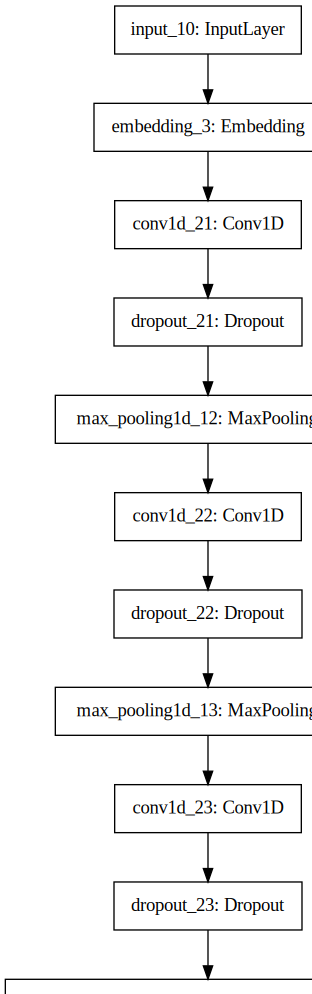

In [59]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(16, 5, activation="relu")(embedded_sequences)
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(16, 5, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(16, 5, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(2, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Train the model

First, convert our list-of-strings data to NumPy arrays of integer indices. The arrays
are right-padded.

In [60]:
x_train = vectorizer(np.array([[s] for s in X])).numpy()
x_val = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y)
y_val = np.array(y_test)

In [61]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
model.fit(x_train, y_train, batch_size=64, epochs=15,validation_data=(x_val,y_val))

Epoch 1/15
625/625 [==============================] - 13s 20ms/step - loss: 0.6788 - acc: 0.5645 - val_loss: 0.5373 - val_acc: 0.7800
Epoch 2/15
625/625 [==============================] - 12s 19ms/step - loss: 0.4425 - acc: 0.8024 - val_loss: 0.4360 - val_acc: 0.8240
Epoch 3/15
625/625 [==============================] - 12s 19ms/step - loss: 0.3499 - acc: 0.8518 - val_loss: 0.4093 - val_acc: 0.8540
Epoch 4/15
625/625 [==============================] - 12s 19ms/step - loss: 0.3004 - acc: 0.8791 - val_loss: 0.3964 - val_acc: 0.8750
Epoch 5/15
625/625 [==============================] - 12s 19ms/step - loss: 0.2726 - acc: 0.8921 - val_loss: 0.3549 - val_acc: 0.8768
Epoch 6/15
625/625 [==============================] - 12s 19ms/step - loss: 0.2447 - acc: 0.9025 - val_loss: 0.3306 - val_acc: 0.8772
Epoch 7/15
625/625 [==============================] - 12s 19ms/step - loss: 0.2194 - acc: 0.9191 - val_loss: 0.3261 - val_acc: 0.8826
Epoch 8/15
625/625 [==============================] - 12s 19ms

In [ ]:
# string_input = keras.Input(shape=(1,), dtype="string")
# x = vectorizer(string_input)
# preds = model(x)
# end_to_end_model = keras.Model(string_input, preds)

# probabilities = end_to_end_model.predict(
#     # [["this message is about computer graphics and 3D modeling"]]
#     [[ test.text[2]]]
# )

# np.argmax(probabilities[0]),test.label[2]

In [62]:
string_input = keras.Input(shape=(None,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

# train data
probabilities = end_to_end_model.predict(
    # [["this message is about computer graphics and 3D modeling"]]
    data.text
)

y_pred=[np.argmax(prob) for prob in probabilities]
print("testing training data")
print(classification_report(data.label, y_pred))

# test data
probabilities = end_to_end_model.predict(
    # [["this message is about computer graphics and 3D modeling"]]
    test.text
)

y_pred=[np.argmax(prob) for prob in probabilities]
print("testing test data")
print(classification_report(test.label, y_pred))


testing training data
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     20019
           1       0.99      0.98      0.99     19981

    accuracy                           0.99     40000
   macro avg       0.99      0.99      0.99     40000
weighted avg       0.99      0.99      0.99     40000

testing test data
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2495
           1       0.89      0.86      0.88      2505

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx